## Imports and helper function

In [67]:
# Imports and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib import gridspec

In [68]:
#Random seed for reproducibility
RANDOM_SEED = 42

In [81]:
# data = pd.read_csv('../data/Trips_2018.csv') 
data = pd.read_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv')

In [82]:
stations_start = (
    data[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
    .drop_duplicates()
    .rename(columns={
        'start_station_id': 'station_id',
        'start_station_latitude': 'station_latitude',
        'start_station_longitude': 'station_longitude'
    })
)

stations_end = (
    data[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
    .drop_duplicates()
    .rename(columns={
        'end_station_id': 'station_id',
        'end_station_latitude': 'station_latitude',
        'end_station_longitude': 'station_longitude'
    })
)

stations = (
    pd.concat([stations_start, stations_end])
    .drop_duplicates()
    .reset_index(drop=True)
)


In [83]:
stations.groupby('station_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(5)

station_id  counts
268       530.0       2
0          72.0       1
570      3388.0       1
560      3376.0       1
561      3377.0       1

In [84]:
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)
stations = stations.drop_duplicates(subset=['station_id', 'station_latitude', 'station_longitude'])

In [76]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17545760 entries, 0 to 17545759
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
 13  pickup_hour              int64  
 14  pickup_day               object 
 15  dropoff_hour             int64  
 16  dropoff_day              object 
dtypes: float64(6), int64(6), object(5)
memory usage: 2.2+ GB


In [86]:
start_stations_set = set(data['start_station_id'].unique())
end_stations_set = set(data['end_station_id'].unique())

def categorize_station(station_id):
    in_start = station_id in start_stations_set
    in_end = station_id in end_stations_set
    if in_start and in_end:
        return 'both'
    elif in_start:
        return 'start'
    elif in_end:
        return 'end'
    else:
        return 'No station id'

stations['category'] = stations['station_id'].apply(categorize_station)
stations = stations[stations['category'] != 'No station id']


Text(0, 0.5, 'Latitude')

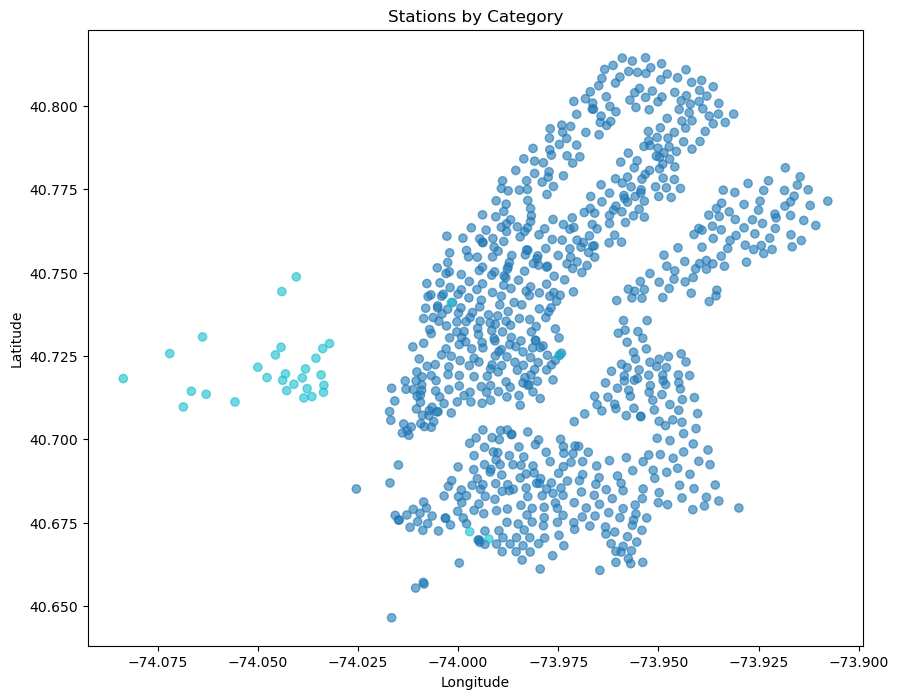

In [87]:
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [89]:
# Extract unique start stations
stations_start = (
    data[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
    .drop_duplicates()
    .rename(columns={
        'start_station_id': 'station_id',
        'start_station_latitude': 'station_latitude',
        'start_station_longitude': 'station_longitude'
    })
)

# Extract unique end stations
stations_end = (
    data[['end_station_id', 'end_station_latitude', 'end_station_longitude']]
    .drop_duplicates()
    .rename(columns={
        'end_station_id': 'station_id',
        'end_station_latitude': 'station_latitude',
        'end_station_longitude': 'station_longitude'
    })
)

# Combine and deduplicate
stations = (
    pd.concat([stations_start, stations_end])
    .drop_duplicates()
    .reset_index(drop=True)
)

# Clean rounding
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)

# Final deduplication
stations = stations.drop_duplicates(
    subset=['station_id', 'station_latitude', 'station_longitude']
)

stations.info()


<class 'pandas.core.frame.DataFrame'>
Index: 848 entries, 0 to 848
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         848 non-null    float64
 1   station_latitude   848 non-null    float64
 2   station_longitude  848 non-null    float64
dtypes: float64(3)
memory usage: 26.5 KB


In [91]:
# Build sets of start and end station IDs
start_stations_set = set(data['start_station_id'].unique())
end_stations_set = set(data['end_station_id'].unique())

# Categorization function
def categorize_station(station_id):
    in_start = station_id in start_stations_set
    in_end = station_id in end_stations_set
    
    if in_start and in_end:
        return 'both'
    elif in_start:
        return 'start'
    elif in_end:
        return 'end'
    else:
        return 'No station id'

# Add category column
stations['category'] = stations['station_id'].apply(categorize_station)

# Remove invalid IDs
stations = stations[stations['category'] != 'No station id']


Text(0, 0.5, 'Latitude')

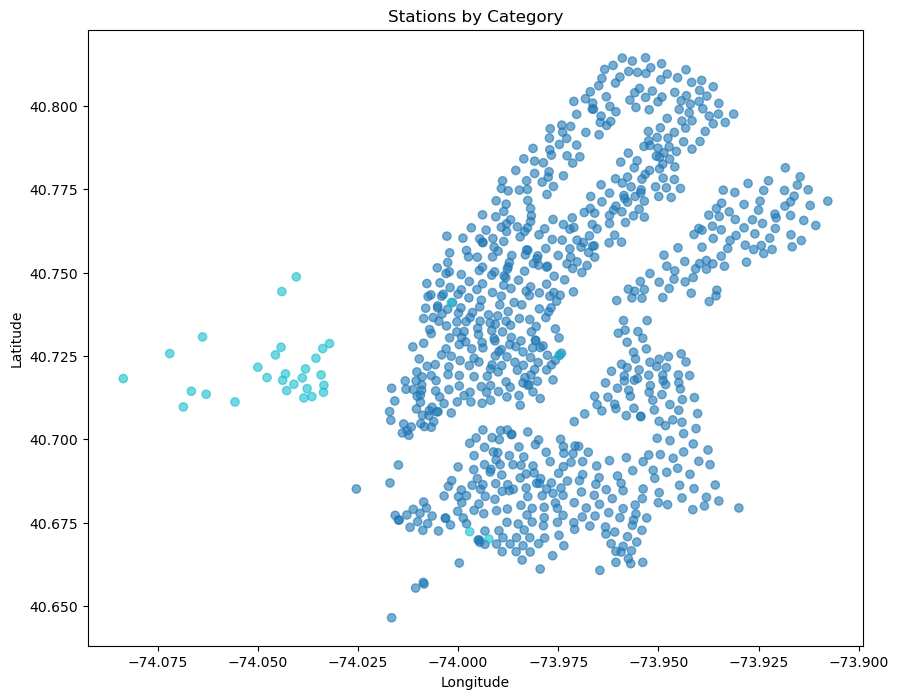

In [92]:
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [93]:
# Rounds all station latitude and longitude values to four decimals and removes any duplicate stations based on identical IDs and coordinates
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)
stations = stations.drop_duplicates(subset=['station_id', 'station_latitude', 'station_longitude'])

In [94]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848 entries, 0 to 848
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         848 non-null    float64
 1   station_latitude   848 non-null    float64
 2   station_longitude  848 non-null    float64
 3   category           848 non-null    object 
dtypes: float64(3), object(1)
memory usage: 33.1+ KB


In [96]:
# Use correct station ID columns from the data
start_stations_set = set(data['start_station_id'].unique())
end_stations_set = set(data['end_station_id'].unique())

def categorize_station(station_id):
    in_start = station_id in start_stations_set
    in_end = station_id in end_stations_set
    
    if in_start and in_end:
        return 'both'
    elif in_start:
        return 'start'
    elif in_end:
        return 'end'
    else:
        return 'No station id'

stations['category'] = stations['station_id'].apply(categorize_station)
stations = stations[stations['category'] != 'No station id']


Text(0, 0.5, 'Latitude')

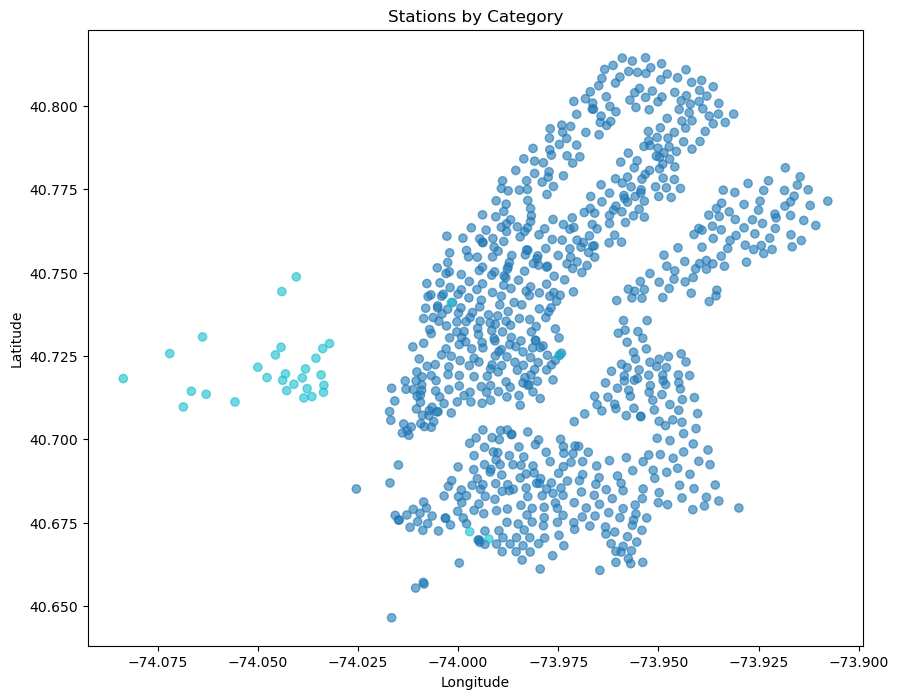

In [97]:
# Converts station categories into numeric color codes and plots all stations on a scatterplot colored by category to visualize their spatial distribution
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Clustering

In [98]:
# Defines helper functions to visualize station clusters, determine the optimal number of K-Means clusters using the elbow method, and evaluate clustering quality using silhouette scores
def plot_station_clusters(df):
    n_clusters = len(set(df["station_cluster"]))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, x='station_longitude', y='station_latitude', hue='station_cluster', palette='tab20', ax=ax)
    ax.set_title(f'Station Clusters (n={n_clusters})')

def elbow_method(data, max_k):
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 31), sse, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.xticks(range(1, 31))
    plt.show()

def silloute_score_plot(data, max_k):
    scores = []
    for k in range(20, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        scores.append(score)
    plt.figure(figsize=(10, 6))
    plt.plot(range(20, max_k + 1), scores, marker='o')
    plt.title('Silhouette Score For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(20, max_k + 1))
    plt.show()

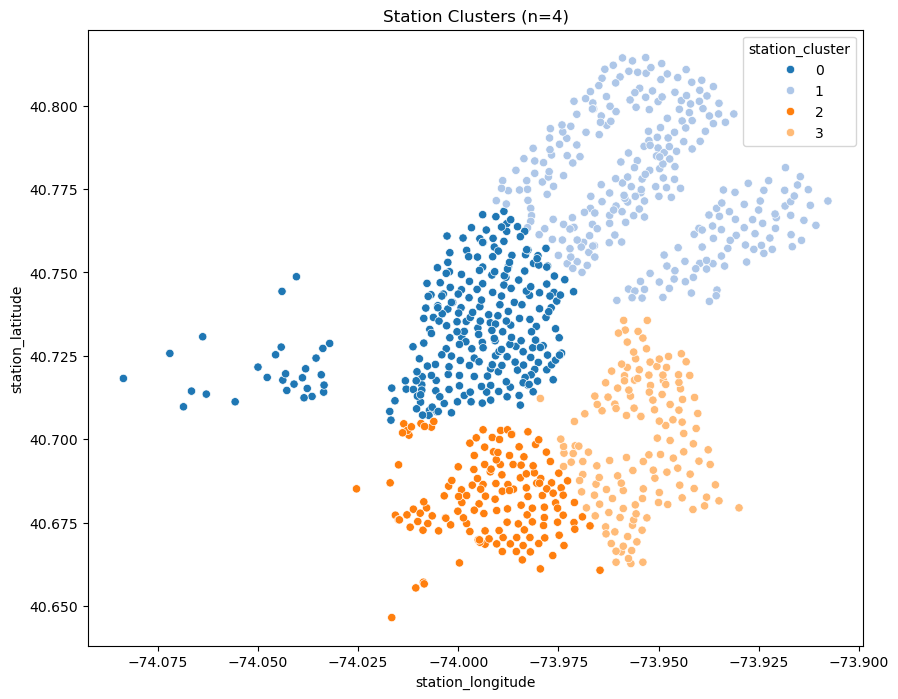

In [99]:
# Performs K-Means clustering with four clusters on station coordinates, assigns each station a cluster label, and visualizes the resulting clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_
plot_station_clusters(stations)

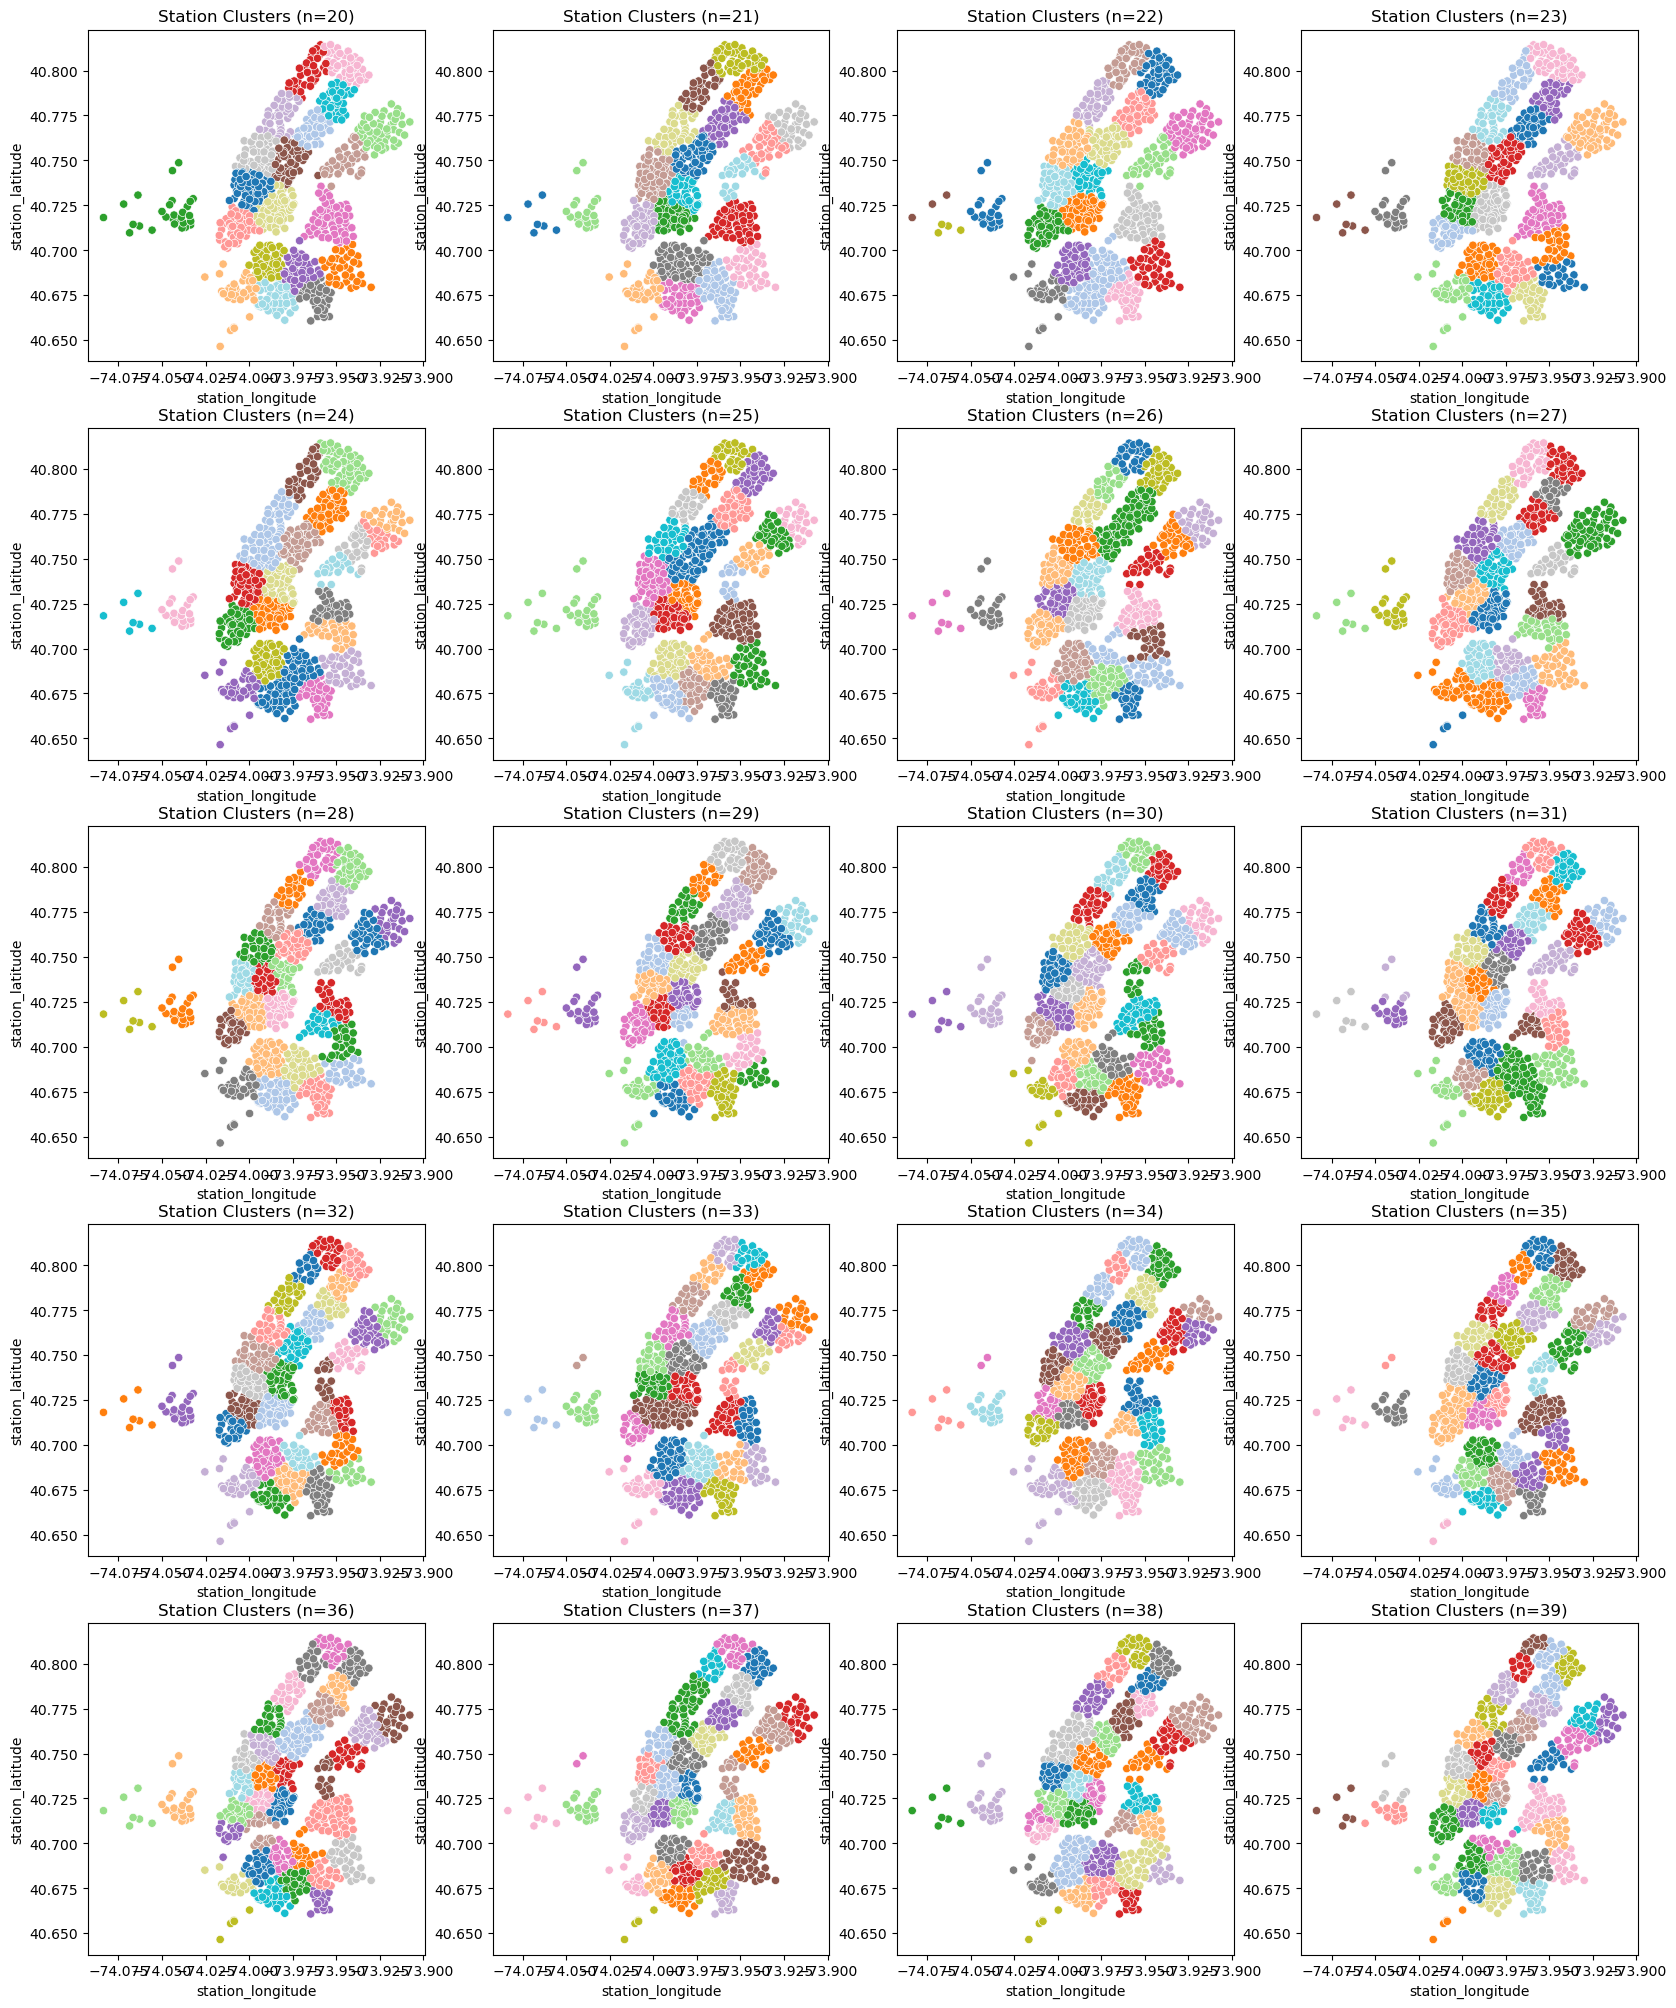

In [100]:
# Iteratively applies K-Means with 20 to 39 clusters and visualizes each clustering configuration in a 5×4 subplot grid to compare spatial patterns across different cluster counts
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=n_clusters+19)
    kmeans.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = kmeans.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+19})')

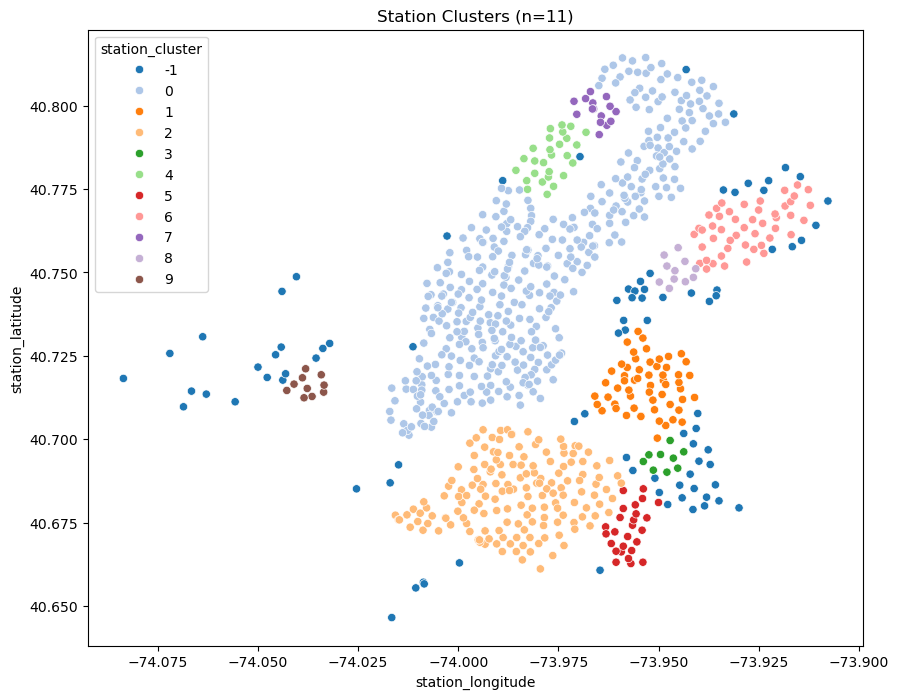

In [101]:
# Applies DBSCAN density-based clustering to the station coordinates using a fixed epsilon and minimum sample size, assigns cluster labels, and visualizes the resulting spatial clusters

dbscan = DBSCAN(eps=0.006, min_samples=10)
dbscan.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = dbscan.labels_
plot_station_clusters(stations)

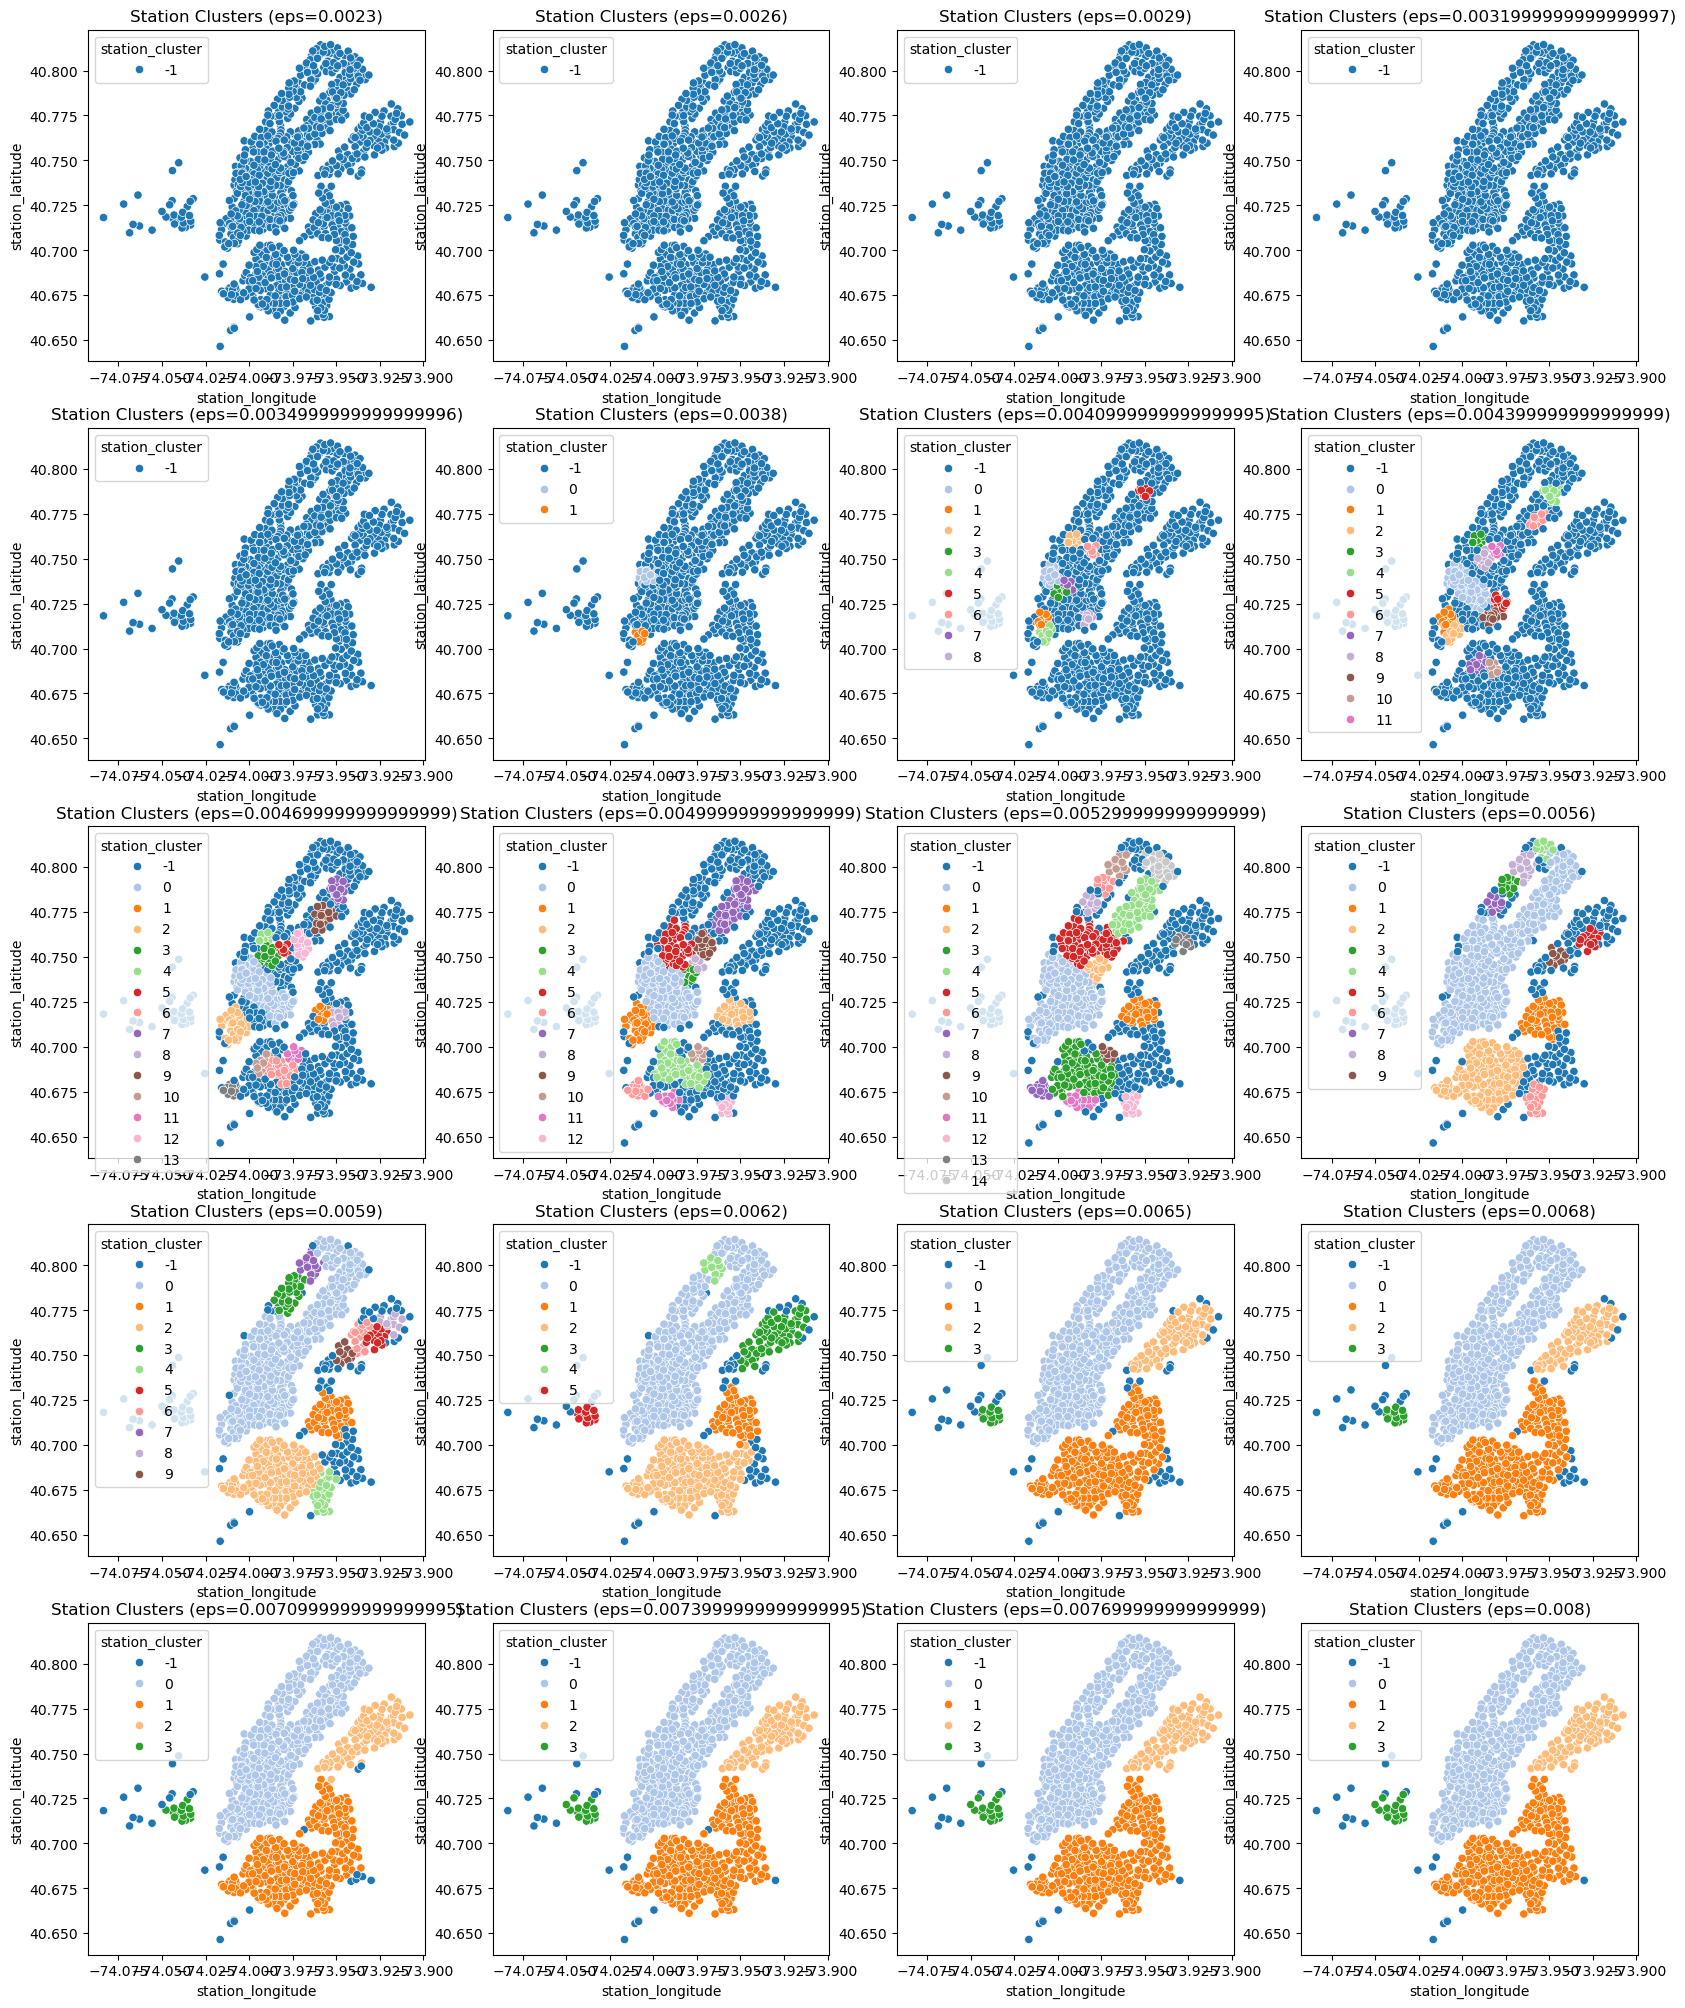

In [102]:
# Runs DBSCAN with 20 increasing epsilon values to analyze how cluster shapes and counts change with density thresholds, visualizing each result in a 5×4 subplot grid

fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for i in range(1, 21):
    eps = 0.002+0.0003*i
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = dbscan.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend="full", hue='station_cluster', palette='tab20', ax=ax[(i-1)//4, (i-1)%4])
    ax[(i-1)//4, (i-1)%4].set_title(f'Station Clusters (eps={eps})')

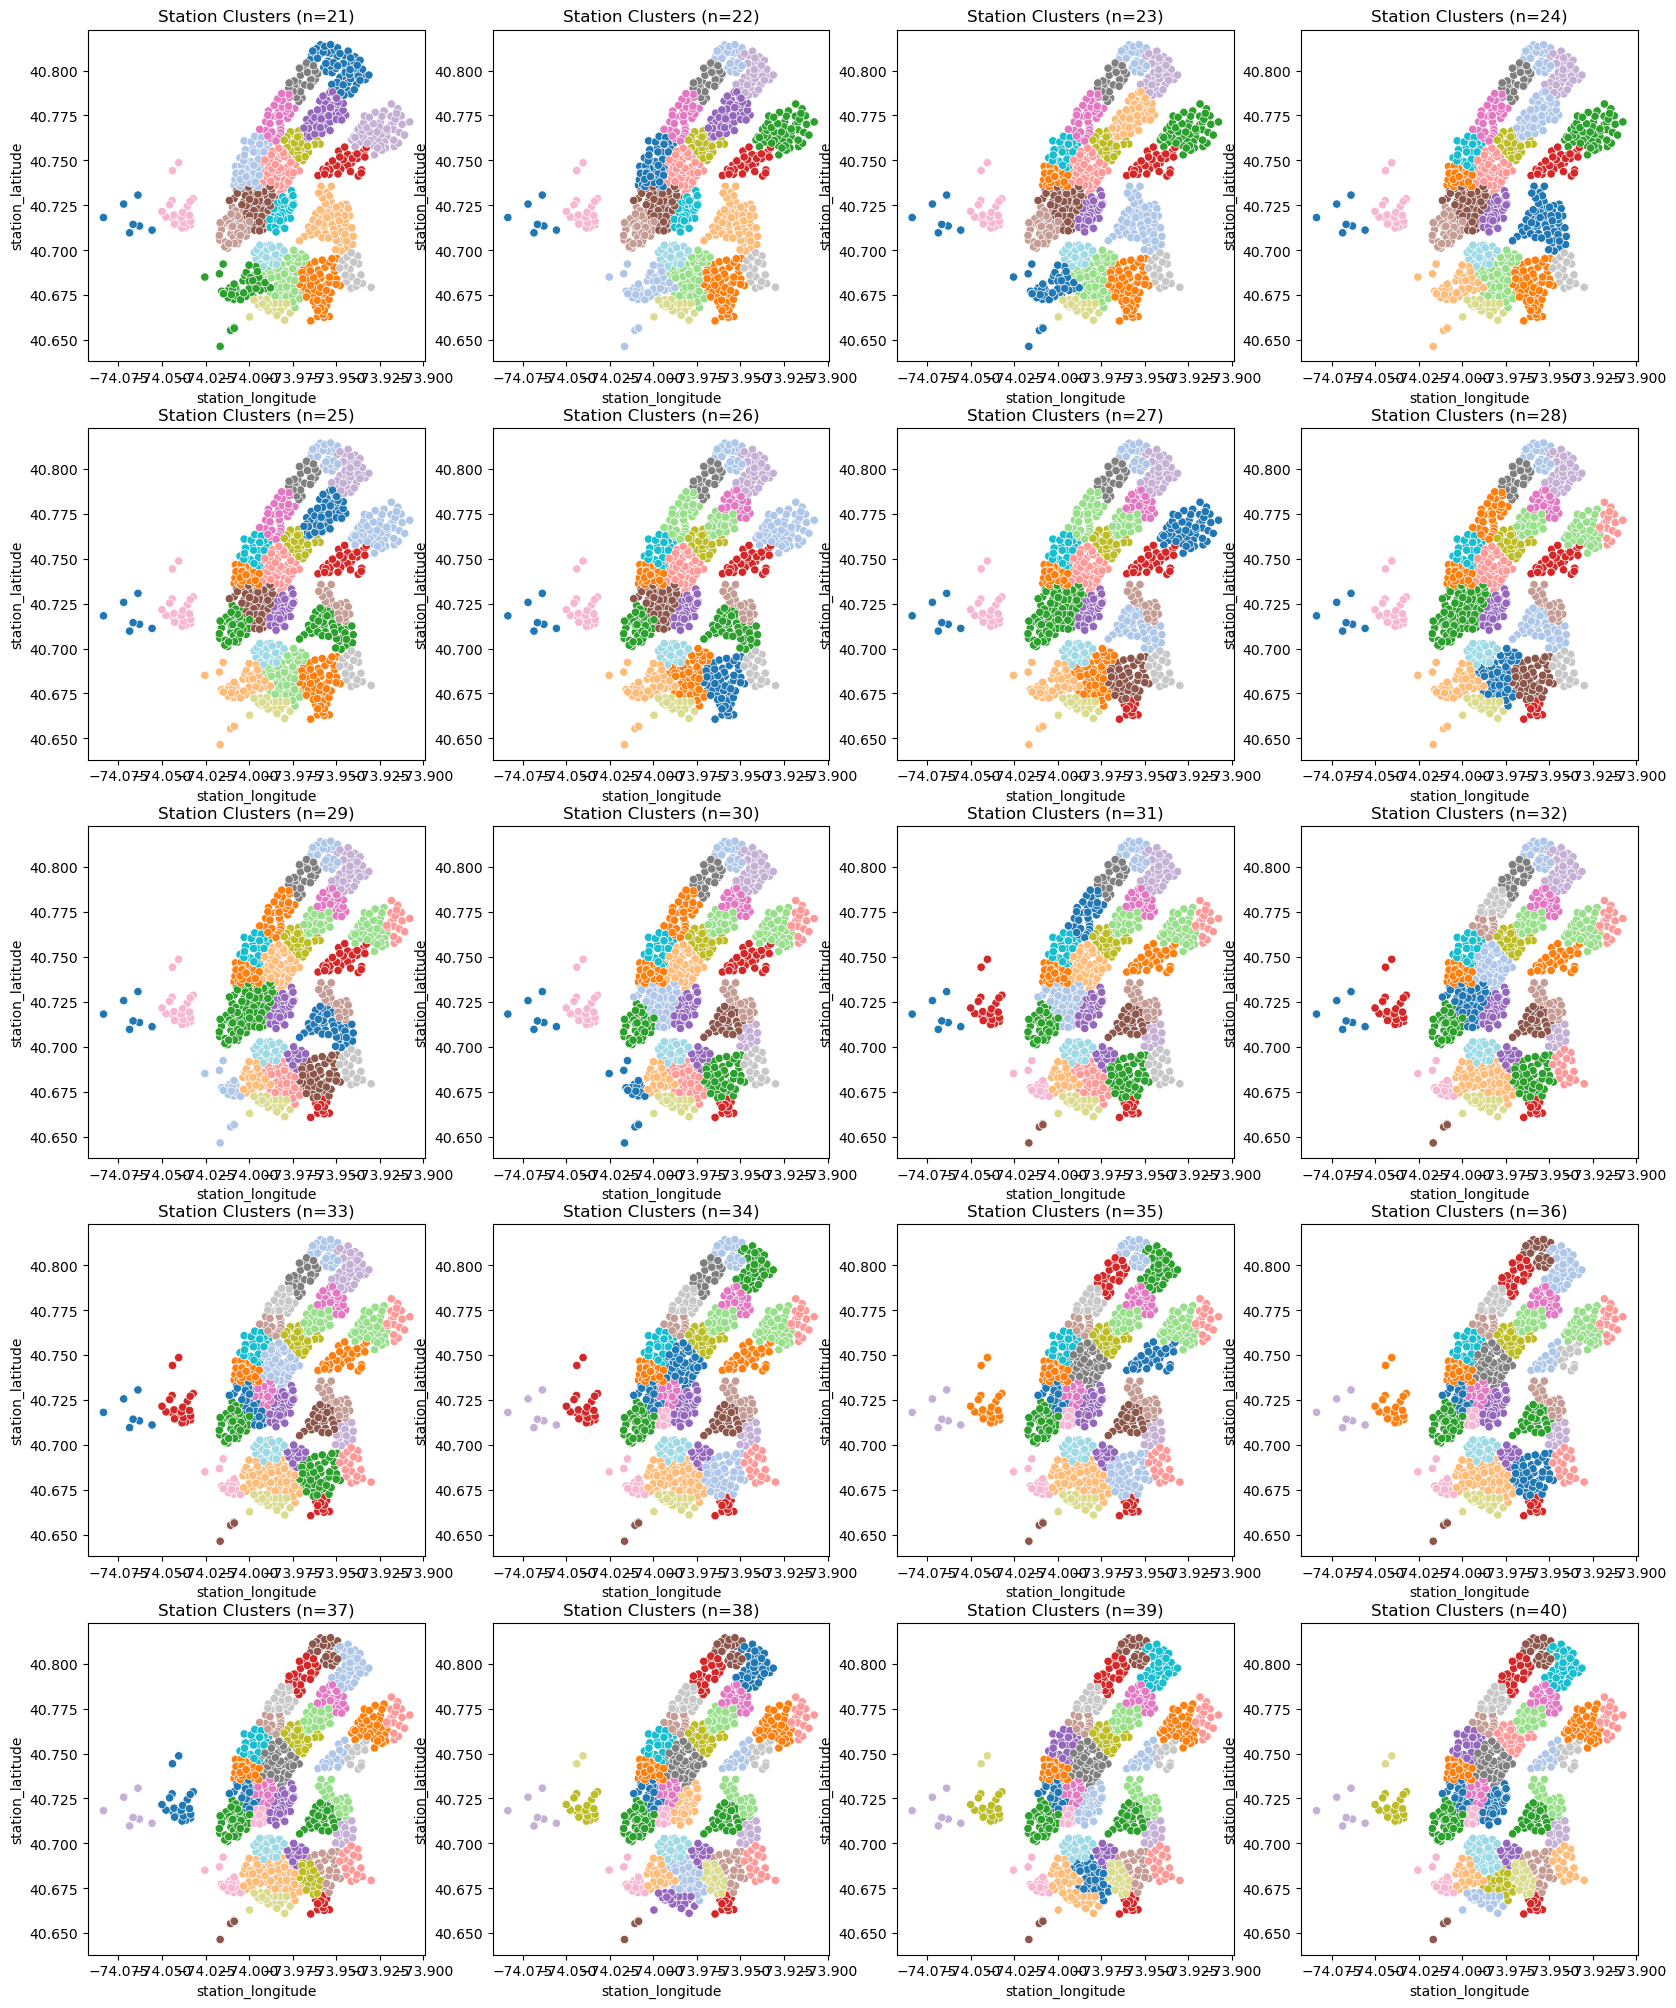

In [103]:
# Applies Agglomerative Clustering with 21 to 40 clusters across a 5×4 subplot grid to compare how hierarchical clustering partitions the station locations at different cluster counts
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    agglo = AgglomerativeClustering(n_clusters=n_clusters+20)
    agglo.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = agglo.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+20})')

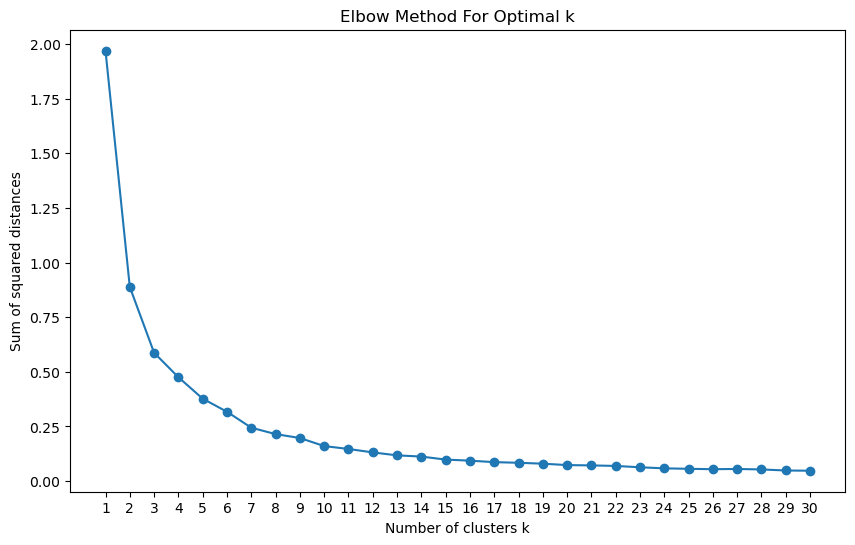

In [104]:
# Computes and visualizes the SSE curve for 1 to 30 clusters to identify the optimal K-Means cluster count using the elbow method
elbow_method(stations[['station_longitude', 'station_latitude']], 30)

In [105]:
# Performs final K-Means clustering with 20 clusters on station coordinates and stores the cluster labels (shifted by +1) as the final station cluster assignments
kmeans = KMeans(n_clusters=20, random_state=RANDOM_SEED)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_+1

In [106]:
# Saves the updated stations DataFrame, including all assigned cluster labels, back to the CSV file without an index
stations.to_csv('/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv', index=False)

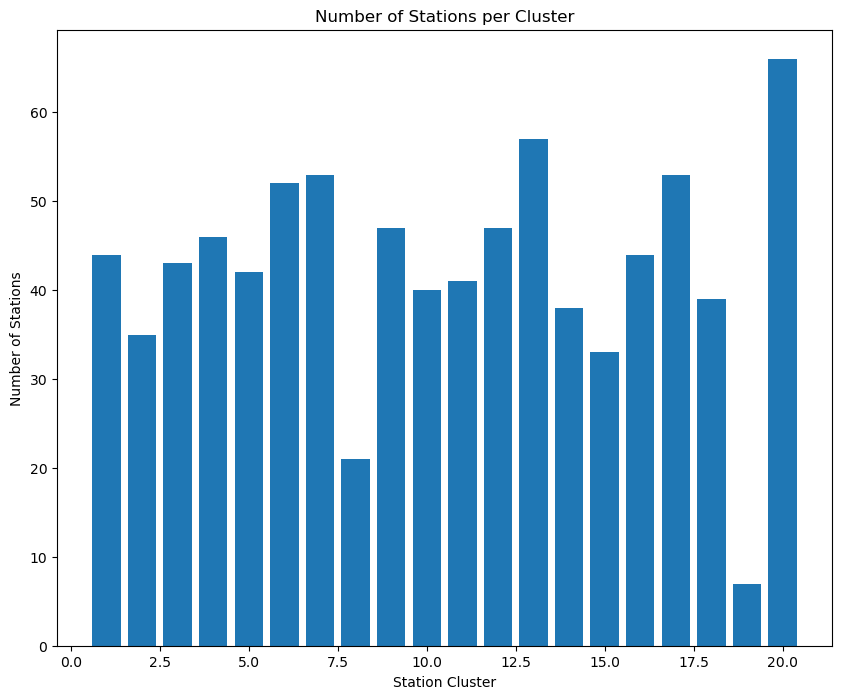

In [107]:
# Calculates the number of stations in each cluster and visualizes the distribution using a bar chart
sizes=stations.groupby('station_cluster').size()
fig = plt.figure(figsize=(10, 8))
plt.bar(sizes.index, sizes.values)
plt.xlabel('Station Cluster')
plt.ylabel('Number of Stations')
plt.title('Number of Stations per Cluster')
plt.show()

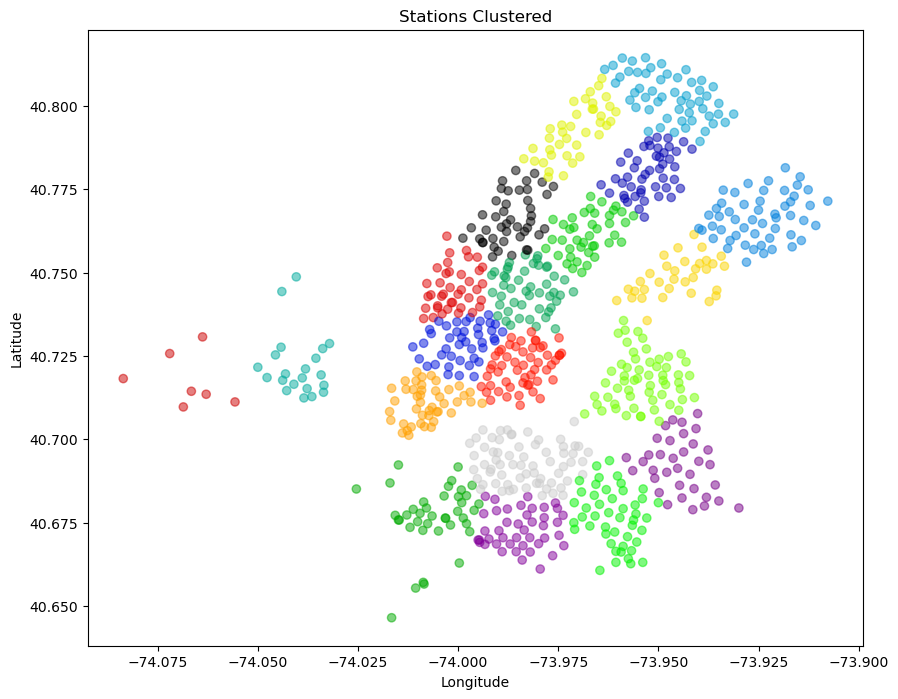

In [108]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(stations['station_longitude'], stations['station_latitude'], c=stations['station_cluster'], cmap='nipy_spectral', alpha=0.5)
plt.title('Stations Clustered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Correlation between hour of day and avg rentals: 0.498


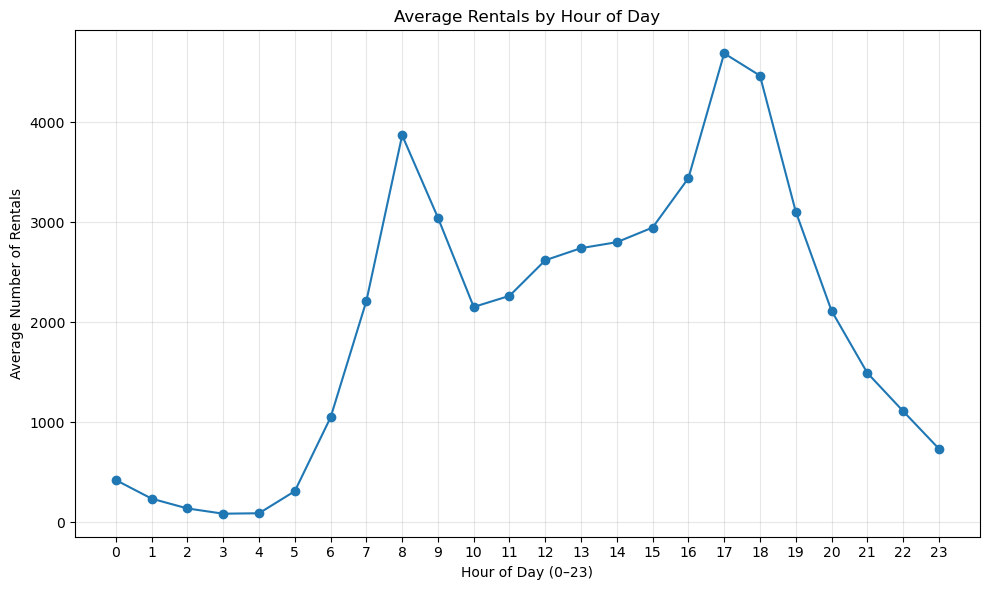

In [109]:
# Creates time-based pickup features, calculates the average number of rentals for each hour of the day, computes the correlation between hour-of-day and demand, and visualizes the hourly rental pattern in a line plot
# Create pickup features from starttime
data['pickup_datetime'] = pd.to_datetime(data['starttime'])
data['pickup_day'] = data['pickup_datetime'].dt.date
data['pickup_hour'] = data['pickup_datetime'].dt.hour   # 0..23

# Average rentals per hour over all days
bikes_per_slot = (
    data
    .groupby(['pickup_day', 'pickup_hour'])
    .size()
    .reset_index(name='num_rentals')
)

avg_per_hour = (
    bikes_per_slot
    .groupby('pickup_hour')['num_rentals']
    .mean()
    .reset_index(name='avg_num_rentals')
)

# Correlation between hour-of-day and average rentals
corr = avg_per_hour['pickup_hour'].corr(avg_per_hour['avg_num_rentals'])
print(f"Correlation between hour of day and avg rentals: {corr:.3f}")

# Plot: average rentals by hour-of-day
fig = plt.figure(figsize=(10, 6))
plt.plot(
    avg_per_hour['pickup_hour'],
    avg_per_hour['avg_num_rentals'],
    marker='o'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Number of Rentals')
plt.title('Average Rentals by Hour of Day')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

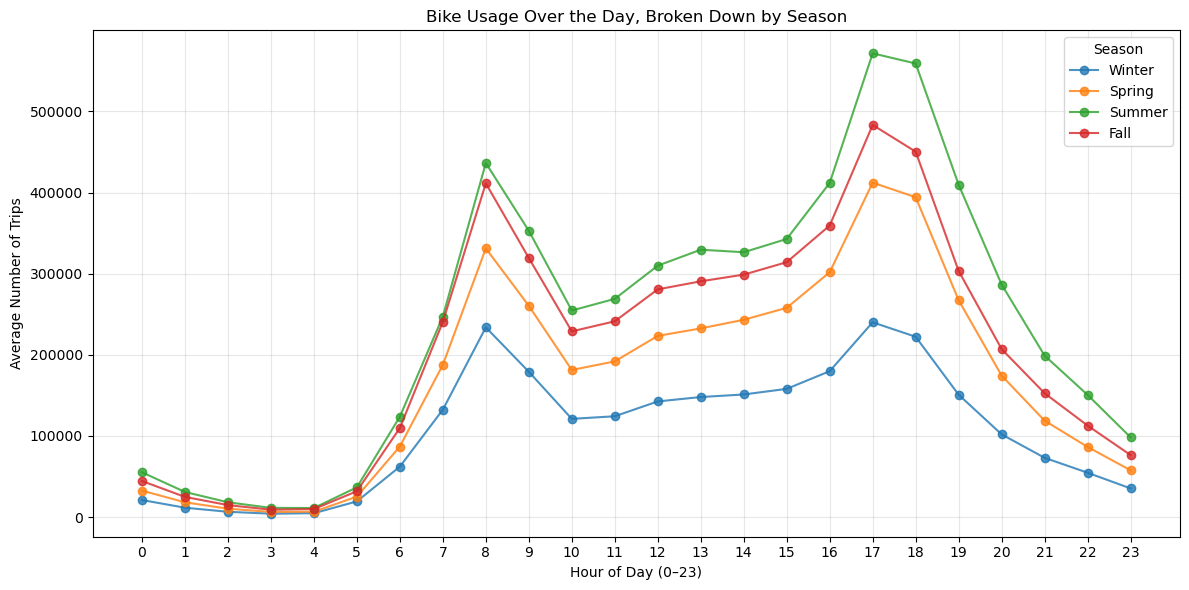

In [ ]:
# Extracts seasonal labels from trip dates, computes average hourly bike usage for each season, and visualizes seasonal demand patterns across the 24-hour day in a line plot
# Extract month and assign seasons

data['pickup_month'] = data['pickup_datetime'].dt.month

def get_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['pickup_month'].apply(get_season)

# Aggregate average trips per hour for each season

trips_hour_season = (
    data
    .groupby(['season', 'pickup_hour'])
    .size()
    .reset_index(name='num_trips')
)

avg_hour_season = (
    trips_hour_season
    .groupby(['season', 'pickup_hour'])['num_trips']
    .mean()
    .reset_index()
)

# Ensure correct seasonal ordering
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
avg_hour_season['season'] = pd.Categorical(avg_hour_season['season'], season_order)

# Line plot: Hourly usage for each season

fig, ax = plt.subplots(figsize=(12, 6))

for season in season_order:
    subset = avg_hour_season[avg_hour_season['season'] == season]
    ax.plot(
        subset['pickup_hour'],
        subset['num_trips'],
        marker='o',
        alpha=0.8,
        label=season
    )

ax.set_xticks(range(0, 24))
ax.set_xlabel('Hour of Day (0–23)')
ax.set_ylabel('Average Number of Trips')
ax.set_title('Bike Usage Over the Day, Broken Down by Season')
ax.legend(title='Season')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/3720620322.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/3720620322.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(c + 1) for c in present_clusters])


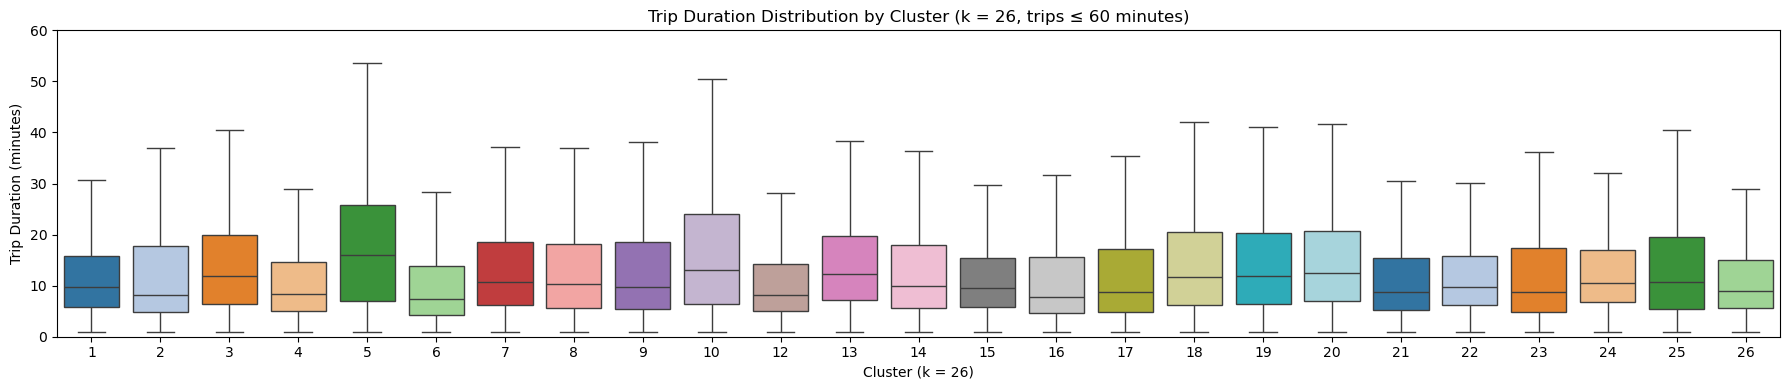

In [ ]:
# Clusters stations into 26 K-means groups after filtering spatial outliers, links trips to their cluster, limits analysis to trips under 60 minutes, 
# and plots duration distributions across clusters using color-aligned boxplots.

k = 26

# Remove spatial outliers using z-score threshold
coords = stations[['station_latitude', 'station_longitude']].dropna()
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

stations_k26 = stations.loc[mask_no_outliers].copy()

# Standardize coordinates and run K-Means
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_k26[['station_latitude', 'station_longitude']]
)

kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
stations_k26['cluster_k26'] = kmeans.fit_predict(coords_scaled)

# Color palette consistent with earlier cluster plots
palette = sns.color_palette('tab20', k)
color_map = {i: palette[i] for i in range(k)}

# Map each station_id to its assigned cluster  **(FIXED)**
cluster_map_26 = (
    stations_k26
    .drop_duplicates('station_id')
    .set_index('station_id')['cluster_k26']
)

# Attach cluster labels to trips and compute duration in minutes

data_k26 = data.copy()
data_k26['cluster_k26'] = data_k26['start_station_id'].map(cluster_map_26)

# Remove trips whose start stations were outliers
data_k26 = data_k26.dropna(subset=['cluster_k26']).copy()
data_k26['cluster_k26'] = data_k26['cluster_k26'].astype(int)

data_k26['tripduration_min'] = data_k26['tripduration'] / 60.0

# Filter trips <= 60 minutes and create boxplots

cutoff = 60
df_box = data_k26[data_k26['tripduration_min'] <= cutoff].copy()

# Clusters with remaining data (0-based cluster IDs)
present_clusters = sorted(df_box['cluster_k26'].unique())

# Colors in the same order as plotted clusters
box_colors = [color_map[c] for c in present_clusters]

fig = plt.figure(figsize=(18, 4))
ax = sns.boxplot(
    x='cluster_k26',
    y='tripduration_min',
    data=df_box,
    order=present_clusters,
    palette=box_colors,
    showfliers=False
)

plt.xlabel('Cluster (k = 26)')
plt.ylabel('Trip Duration (minutes)')
plt.title(f'Trip Duration Distribution by Cluster (k = 26, trips ≤ {cutoff} minutes)')

plt.ylim(0, cutoff)
plt.yticks(np.arange(0, cutoff + 1, 10))

# Convert x-axis labels from 0-based IDs to 1..26
ax.set_xticklabels([str(c + 1) for c in present_clusters])

plt.tight_layout()
plt.show()


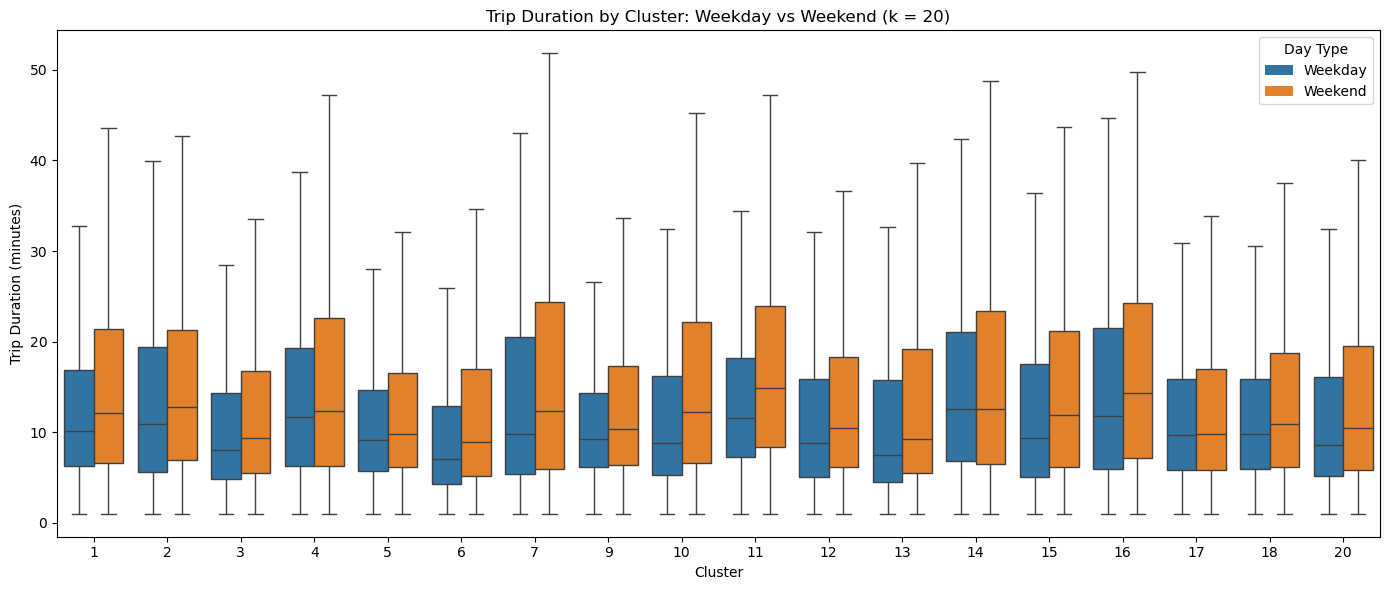

In [ ]:
# Compares weekday and weekend trip duration patterns across all 20 station clusters by assigning each trip to its cluster and visualizing per-cluster duration distributions with a dual-color boxplot.
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    data=data_cl,
    x='station_cluster',
    y='duration_min',
    hue='is_weekend',
    palette=['tab:blue', 'tab:orange'],
    showcaps=True,
    showfliers=False
)

ax.set_title('Trip Duration by Cluster: Weekday vs Weekend (k = 20)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Trip Duration (minutes)')

handles, labels = ax.get_legend_handles_labels()

# Some seaborn versions return Artists directly, some return a tuple (Artist,)
def extract_color(h):
    if isinstance(h, tuple):
        h = h[0]
    return h.get_facecolor()

weekday_color = extract_color(handles[0])
weekend_color = extract_color(handles[1])

# Remove seaborn’s default legend
ax.legend_.remove()

import matplotlib.patches as mpatches

legend_elements = [
    mpatches.Patch(facecolor=weekday_color, label='Weekday'),
    mpatches.Patch(facecolor=weekend_color, label='Weekend')
]

ax.legend(handles=legend_elements, title='Day Type')

plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/279619437.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('start_station_id')


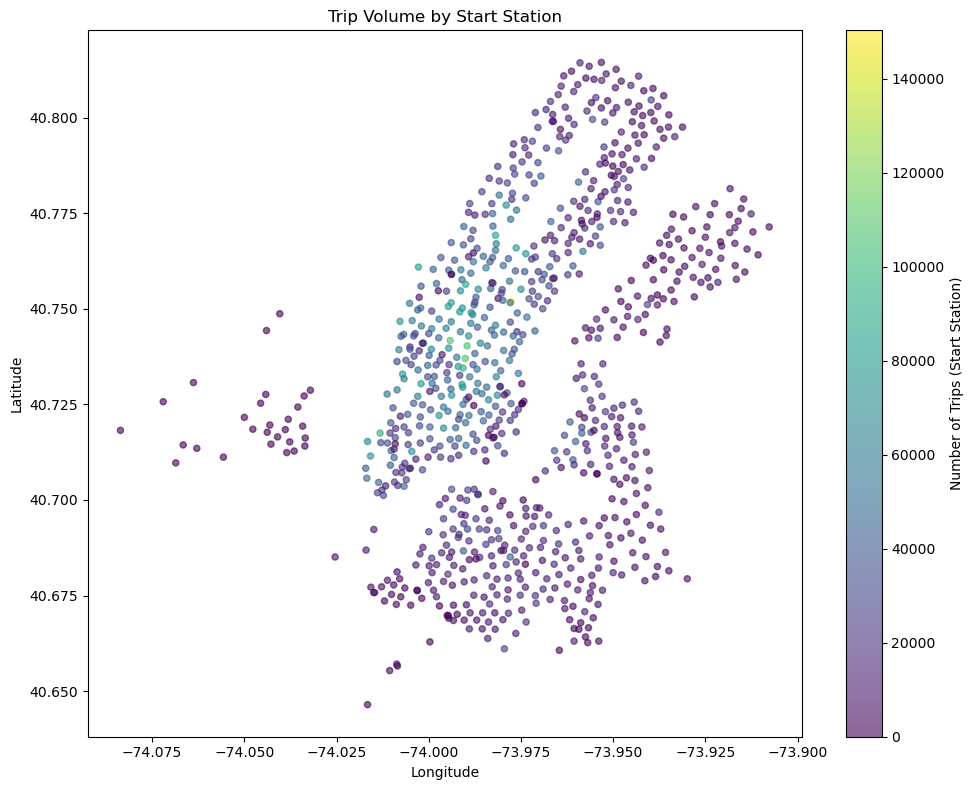

In [ ]:
# Aggregates trip counts per start station, merges them with station coordinates, and visualizes spatial differences in trip volume using a color-coded scatterplot
# Trips per start station
trips_per_station = (
    data
    .groupby('start_station_id')
    .size()
    .reset_index(name='num_trips')
)

# Join with station coordinates (matching earlier merging style)
stations_vol = (
    stations
    .merge(trips_per_station, left_on='station_id', right_on='start_station_id', how='left')
    .fillna({'num_trips': 0})
)

# Scatterplot of trip volume by station
fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(
    stations_vol['station_longitude'],
    stations_vol['station_latitude'],
    c=stations_vol['num_trips'],
    cmap='viridis',
    alpha=0.6,
    s=20
)

plt.colorbar(sc, label='Number of Trips (Start Station)')
ax.set_title('Trip Volume by Start Station')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/20158832.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('start_station_id')
/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/20158832.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('end_station_id')


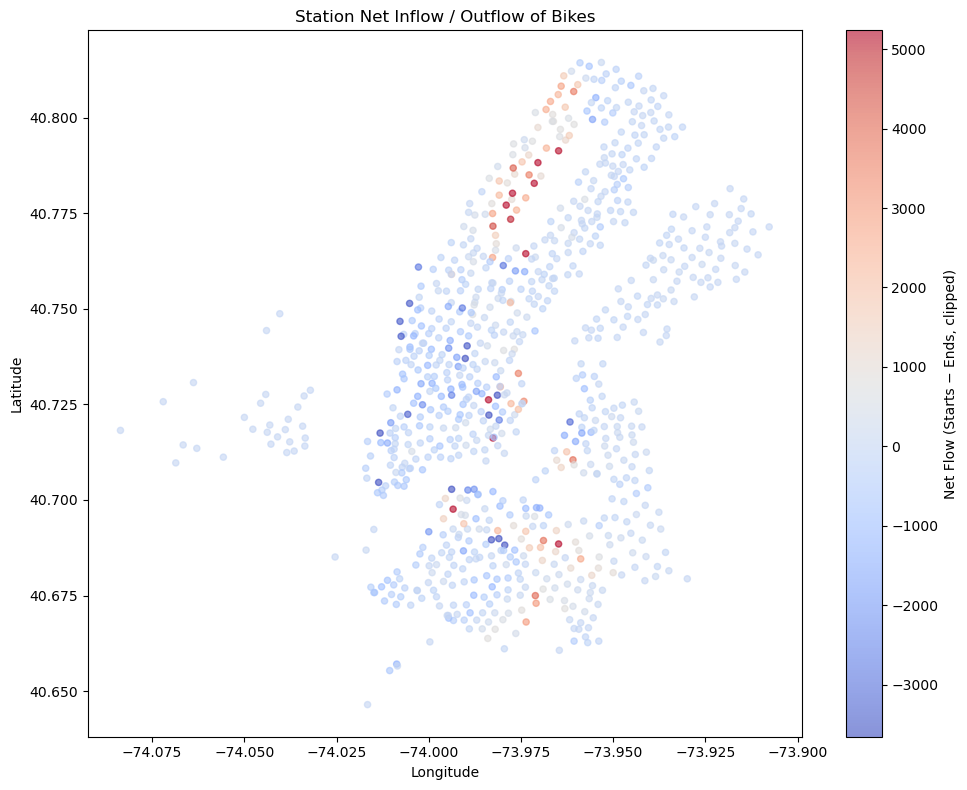

In [ ]:
# Computes the number of trips starting and ending at each station, derives net inflow/outflow, clips extreme values, and visualizes spatial bike imbalances on a coolwarm-colored scatterplot.
# Trips starting at each station
starts = (
    data
    .groupby('start_station_id')
    .size()
    .rename('num_starts')
)

# Trips ending at each station
ends = (
    data
    .groupby('end_station_id')
    .size()
    .rename('num_ends')
)

# Join with station coordinates (matching earlier merging style)
stations_flow = (
    stations
    .merge(starts, left_on='station_id', right_index=True, how='left')
    .merge(ends, left_on='station_id', right_index=True, how='left')
    .fillna({'num_starts': 0, 'num_ends': 0})
)

# Net flow = starts − ends
stations_flow['net_flow'] = stations_flow['num_starts'] - stations_flow['num_ends']

# Clip extreme net flows at 1st / 99th percentile to avoid skewed colors
low, high = stations_flow['net_flow'].quantile([0.01, 0.99])
stations_flow['net_flow_clipped'] = stations_flow['net_flow'].clip(low, high)

# Scatterplot of net flow by station (full dataset, no filtering)
fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(
    stations_flow['station_longitude'],
    stations_flow['station_latitude'],
    c=stations_flow['net_flow_clipped'],
    cmap='coolwarm',
    alpha=0.6,
    s=20
)

plt.colorbar(sc, label='Net Flow (Starts − Ends, clipped)')
ax.set_title('Station Net Inflow / Outflow of Bikes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()


# Red / orange stations → net_flow > 0 → more starts than ends
# These are net exporters of bikes (bikes tend to leave from here and end elsewhere)
# Blue stations → net_flow < 0 → more ends than starts
# These are net importers of bikes (bikes tend to arrive here and start elsewhere)
# Grey / neutral stations → net_flow ≈ 0 → starts and ends are roughly balanced
# Clipped extreme values at the 1st / 99th percentile, so color scale is not dominated by a few huge outliers


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/3729252648.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['start_station_id', 'is_weekend'])


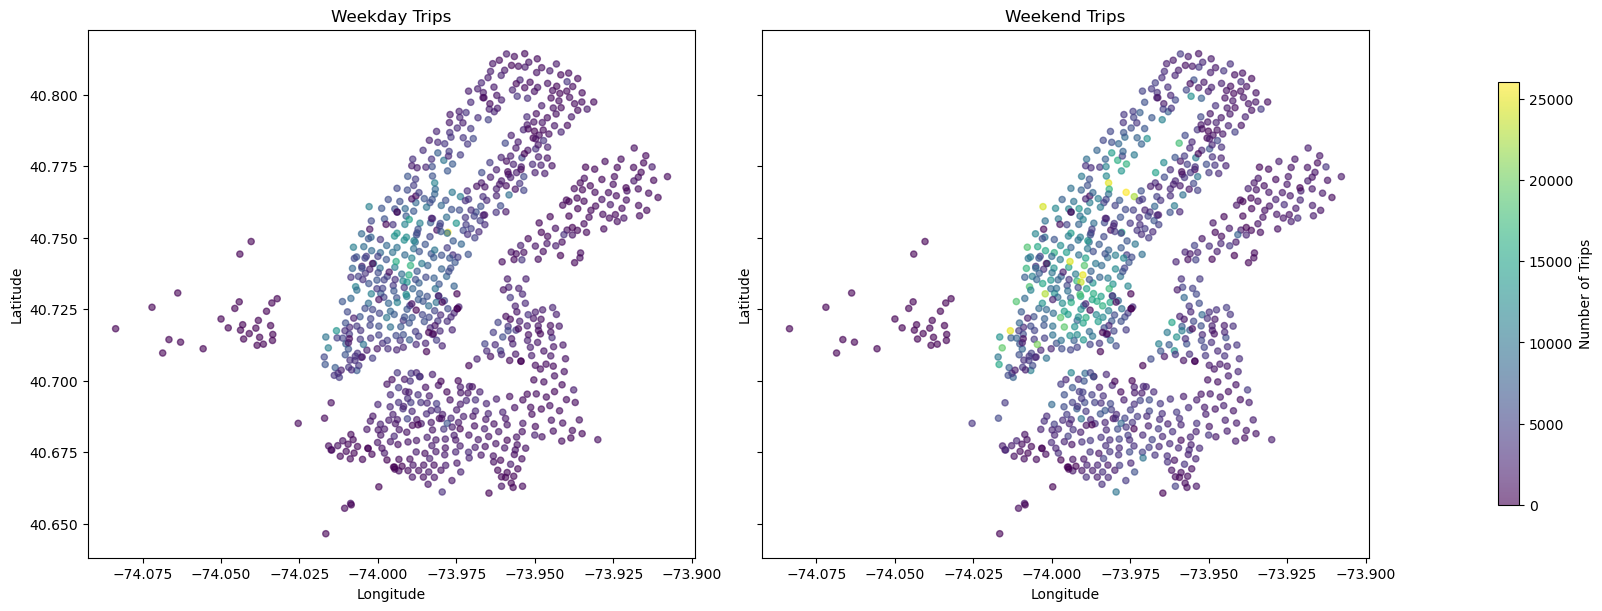

In [ ]:
# Extracts weekday/weekend indicators, aggregates trip counts per start station for both day types, merges them with station coordinates, 
# and visualizes spatial differences in weekday versus weekend demand on side-by-side maps.
# Weekend / Weekday trip features
data['pickup_date'] = data['pickup_datetime'].dt.date
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['is_weekend'] = data['pickup_weekday'] >= 5

# Aggregate weekday and weekend trips per start station
station_week = (
    data
    .groupby(['start_station_id', 'is_weekend'])
    .size()
    .reset_index(name='num_trips')
    .pivot(index='start_station_id', columns='is_weekend', values='num_trips')
    .fillna(0)
    .rename(columns={False: 'weekday_trips', True: 'weekend_trips'})
    .reset_index()
)

# Merge with station coordinates
stations_week = (
    stations
    .merge(station_week, left_on='station_id', right_on='start_station_id', how='left')
    .fillna({'weekday_trips': 0, 'weekend_trips': 0})
)

# Use constrained layout to avoid overlap
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True
)

# Plot weekday and weekend maps
for ax, col, title in zip(
    axes,
    ['weekday_trips', 'weekend_trips'],
    ['Weekday Trips', 'Weekend Trips']
):
    sc = ax.scatter(
        stations_week['station_longitude'],
        stations_week['station_latitude'],
        c=stations_week[col],
        cmap='viridis',
        alpha=0.6,
        s=20
    )
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Add colorbar outside the entire layout
cbar = fig.colorbar(sc, ax=axes, location='right', shrink=0.8, pad=0.08)
cbar.set_label('Number of Trips')

plt.show()


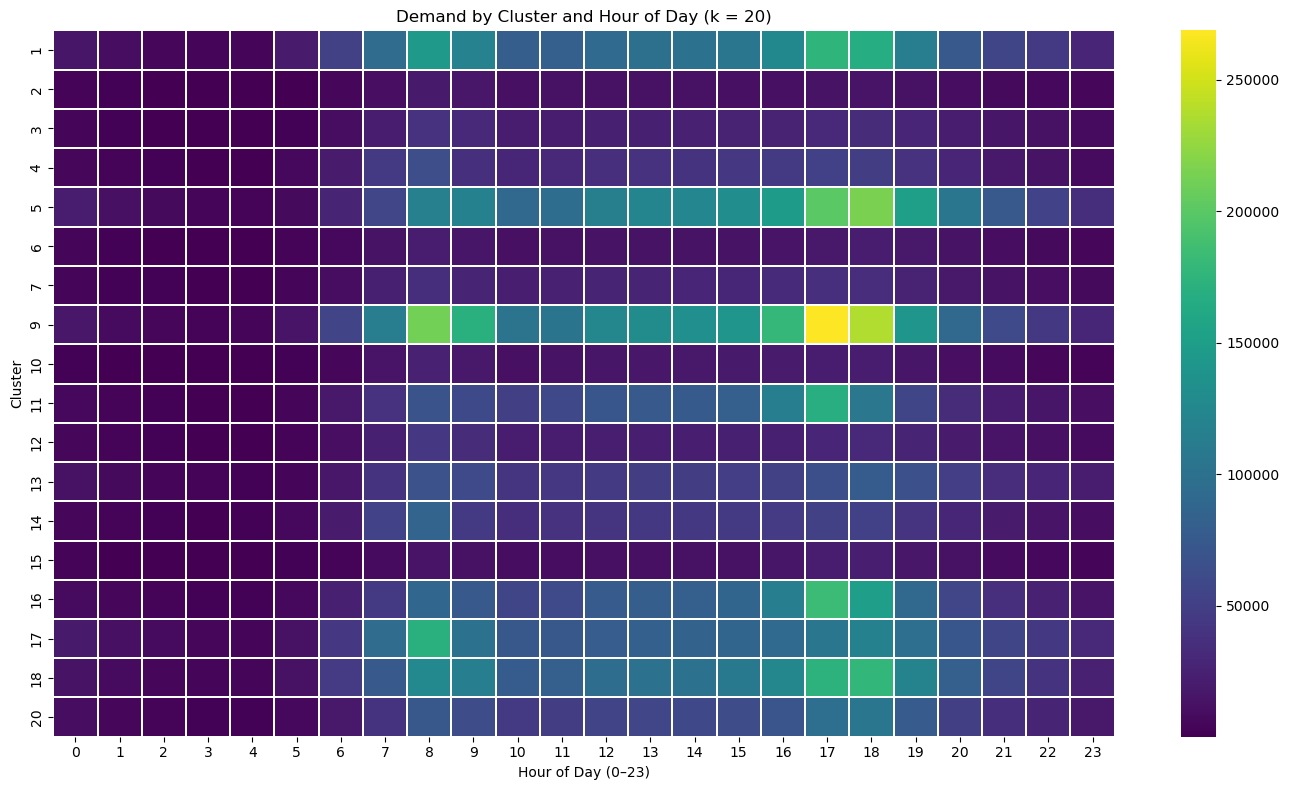

In [ ]:
# Maps each trip to its station cluster, aggregates hourly demand per cluster, reshapes the results into a cluster-by-hour matrix, and visualizes temporal usage patterns with a heatmap
# Attach station cluster labels to each trip

# Map start_station_id → station_cluster (k = 20)
cluster_map_20 = (
    stations
    .drop_duplicates('station_id')
    .set_index('station_id')['station_cluster']
)

data_cluster = data.copy()
data_cluster['station_cluster'] = data_cluster['start_station_id'].map(cluster_map_20)

# Remove trips whose start station has no cluster (rare)
data_cluster = data_cluster.dropna(subset=['station_cluster']).copy()
data_cluster['station_cluster'] = data_cluster['station_cluster'].astype(int)

# Aggregate number of trips by (cluster, hour)

cluster_hour = (
    data_cluster
    .groupby(['station_cluster', 'pickup_hour'])
    .size()
    .reset_index(name='num_trips')
)

# Pivot to matrix: clusters as rows, hours (0–23) as columns
cluster_hour_matrix = (
    cluster_hour
    .pivot(index='station_cluster', columns='pickup_hour', values='num_trips')
    .fillna(0)
    .sort_index()
)

# Heatmap: cluster vs hour

import seaborn as sns
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(
    cluster_hour_matrix,
    cmap='viridis',
    linewidth=0.3,
    linecolor='white'
)

ax.set_title('Demand by Cluster and Hour of Day (k = 20)')
ax.set_xlabel('Hour of Day (0–23)')
ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_89115/3523033184.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['start_station_id', 'is_weekend'])


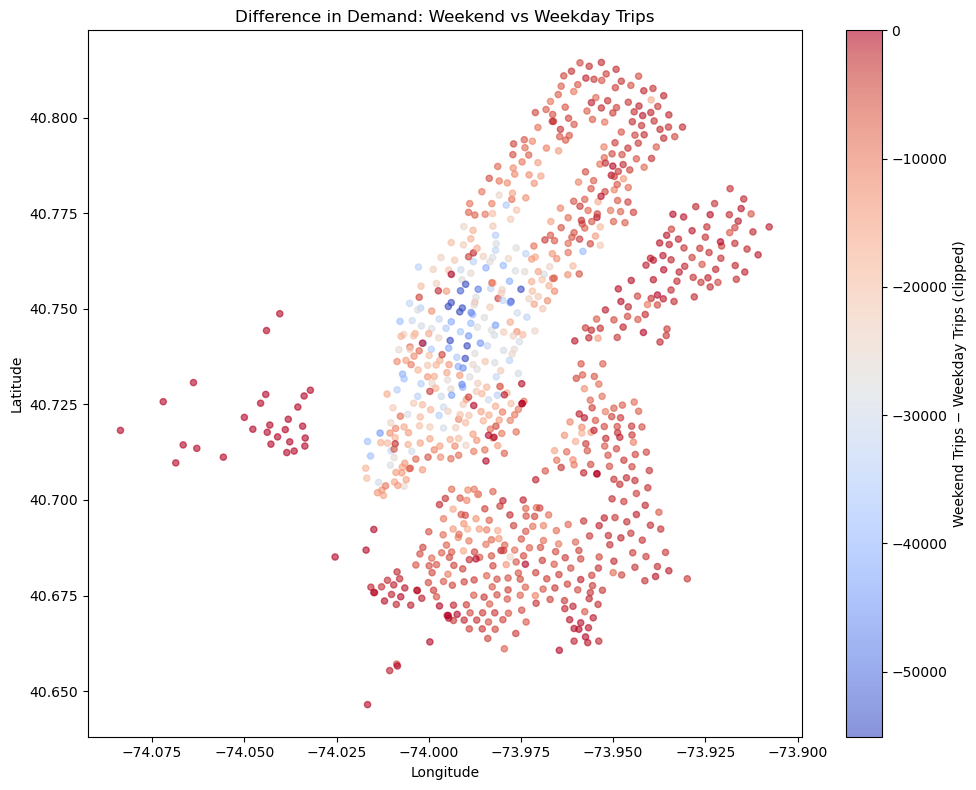

In [ ]:
# Computes weekday and weekend trip volumes per station, derives their difference, clips extreme values, and visualizes spatial demand shifts using a diverging color map
# Create weekend/weekday trip aggregates
data['pickup_date'] = data['pickup_datetime'].dt.date
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['is_weekend'] = data['pickup_weekday'] >= 5

station_week = (
    data
    .groupby(['start_station_id', 'is_weekend'])
    .size()
    .reset_index(name='num_trips')
    .pivot(index='start_station_id', columns='is_weekend', values='num_trips')
    .fillna(0)
    .rename(columns={False: 'weekday_trips', True: 'weekend_trips'})
    .reset_index()
)

# Merge with station coordinates (consistent with earlier code)

stations_week = (
    stations
    .merge(station_week, left_on='station_id', right_on='start_station_id', how='left')
    .fillna({'weekday_trips': 0, 'weekend_trips': 0})
)

# Compute difference: weekend minus weekday

stations_week['weekend_minus_weekday'] = (
    stations_week['weekend_trips'] - stations_week['weekday_trips']
)

# Clip extreme values (1st–99th percentile), same logic used in net-flow map
low, high = stations_week['weekend_minus_weekday'].quantile([0.01, 0.99])
stations_week['diff_clipped'] = stations_week['weekend_minus_weekday'].clip(low, high)

# Plot Difference Map

fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(
    stations_week['station_longitude'],
    stations_week['station_latitude'],
    c=stations_week['diff_clipped'],
    cmap='coolwarm',      # diverging colormap: blue = weekday, red = weekend
    alpha=0.6,
    s=20
)

cbar = fig.colorbar(sc, ax=ax, label='Weekend Trips − Weekday Trips (clipped)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Difference in Demand: Weekend vs Weekday Trips')

plt.tight_layout()
plt.show()


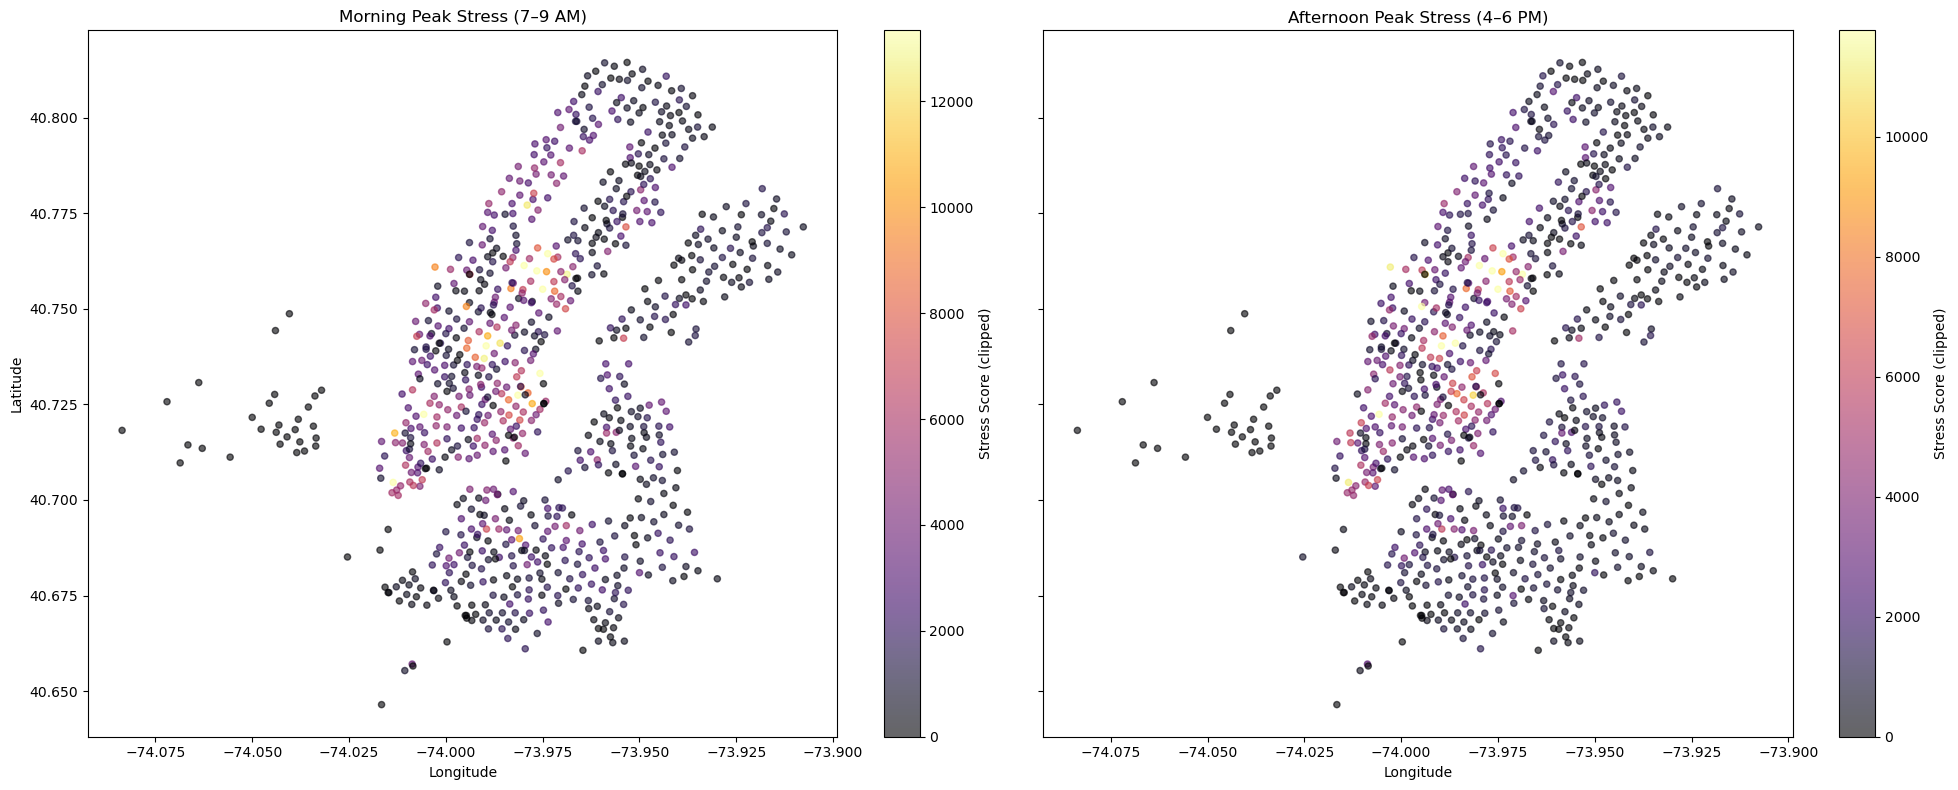

In [ ]:
# Identifies capacity stress during morning and afternoon peak hours by comparing station-level start and end imbalances and visualizing the resulting stress scores on two spatial heatmaps
morning_peak = [7, 8, 9]        # 7–9 AM
afternoon_peak = [16, 17, 18]   # 4–6 PM

def compute_stress_map(data, stations, peak_hours):
    data_p = data[data['pickup_hour'].isin(peak_hours)].copy()

    starts = (
        data_p
        .groupby('start_station_id')
        .size()
        .rename('num_starts')
    )

    ends = (
        data_p
        .groupby('end_station_id')
        .size()
        .rename('num_ends')
    )

    df = (
        stations
        .merge(starts, left_on='station_id', right_index=True, how='left')
        .merge(ends, left_on='station_id', right_index=True, how='left')
        .fillna({'num_starts': 0, 'num_ends': 0})
        .copy()
    )

    df['net_flow'] = df['num_starts'] - df['num_ends']
    df['stress_score'] = df['net_flow'].abs()

    # clip for visualization
    low, high = df['stress_score'].quantile([0.01, 0.99])
    df['stress_clipped'] = df['stress_score'].clip(low, high)

    return df


# Compute morning + afternoon stress
stress_morning = compute_stress_map(data, stations, morning_peak)
stress_afternoon = compute_stress_map(data, stations, afternoon_peak)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

# Morning plot
sc1 = axes[0].scatter(
    stress_morning['station_longitude'],
    stress_morning['station_latitude'],
    c=stress_morning['stress_clipped'],
    cmap='inferno',
    alpha=0.6,
    s=20
)
axes[0].set_title('Morning Peak Stress (7–9 AM)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Stress Score (clipped)')


# Afternoon plot
sc2 = axes[1].scatter(
    stress_afternoon['station_longitude'],
    stress_afternoon['station_latitude'],
    c=stress_afternoon['stress_clipped'],
    cmap='inferno',
    alpha=0.6,
    s=20
)
axes[1].set_title('Afternoon Peak Stress (4–6 PM)')
axes[1].set_xlabel('Longitude')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Stress Score (clipped)')


plt.tight_layout()
plt.show()
